# Clonar el proyecto
*Nota: Asegurarse de estar trabajando con la GPU.*

In [1]:
!git clone https://github.com/nick3153/Fast-ACVNet-ImgProj.git
%cd Fast-ACVNet-ImgProj

Cloning into 'Fast-ACVNet-ImgProj'...
remote: Enumerating objects: 247, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 247 (delta 49), reused 64 (delta 32), pack-reused 152 (from 1)
Receiving objects: 100% (247/247), 101.37 MiB | 15.33 MiB/s, done.
Resolving deltas: 100% (99/99), done.
/content/Fast-ACVNet-ImgProj


# Instalar dependencias necesarias

In [2]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install opencv-python
!pip install scikit-image
!pip install tensorboard
!pip install matplotlib
!pip install tqdm
!pip install timm==0.5.4

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 131.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unins

# Código

In [7]:
#@title Funciones necesarias
from PIL import Image
import matplotlib
import matplotlib.cm as cm
import numpy as np
from torchvision import transforms
import cv2
import torch
import os

def predict_disparity(model, left_path, right_path, output_dir='./disp_rgb/'):
    os.makedirs(output_dir, exist_ok=True)

    # Cargar imágenes RGB con PIL
    limg = Image.open(left_path).convert('RGB')
    rimg = Image.open(right_path).convert('RGB')

    # Asegurar tamaños múltiples de 32
    w, h = limg.size
    wi, hi = (w // 32 + 1) * 32, (h // 32 + 1) * 32
    limg = limg.crop((w - wi, h - hi, w, h))
    rimg = rimg.crop((w - wi, h - hi, w, h))

    # Preprocesamiento: convertir a tensor y normalizar
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    limg_tensor = transform(limg).unsqueeze(0).cuda()
    rimg_tensor = transform(rimg).unsqueeze(0).cuda()

    # Inferencia
    model.eval()
    with torch.no_grad():
        pred_disp = model(limg_tensor, rimg_tensor)[-1]
        pred_disp = pred_disp[:, hi - h:, wi - w:]

    # Convertir a numpy
    pred_np = pred_disp.squeeze().cpu().numpy()

    # Guardar como imagen coloreada
    output_path = os.path.join(output_dir, 'disp_rgb.png')
    pred_np_scaled = np.round(pred_np * 256).astype(np.uint16)
    disp_color = cv2.applyColorMap(cv2.convertScaleAbs(pred_np_scaled, alpha=0.01), cv2.COLORMAP_JET)
    cv2.imwrite(output_path, disp_color)

    print(f"Disparidad guardada en: {output_path}")


def intensity_binding(img, lower_percentile=2, upper_percentile=98):
    low = np.percentile(img, lower_percentile)
    high = np.percentile(img, upper_percentile)
    img_clipped = np.clip(img, low, high)
    img_norm = ((img_clipped - low) / (high - low + 1e-8)) * 255.0
    return img_norm.astype(np.uint8)

def apply_clahe(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(img)

def apply_bilateral(img):
    return cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

def preprocess_thermal_image(image_path):
    # Cargar como imagen en escala de grises
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    # Paso 1: Percentiles
    img = intensity_binding(img, 2, 98)

    # Paso 2: CLAHE
    img = apply_clahe(img)

    # Paso 3: Filtro bilateral
    img = apply_bilateral(img)

    # Convertir a RGB (3 canales) para el modelo
    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Convertir a objeto PIL
    return Image.fromarray(img_rgb)

def test_thermal_pairs(left_imgs, right_imgs):
    os.makedirs('./disp_thermal/', exist_ok=True)

    for i in range(len(left_imgs)):
        limg = preprocess_thermal_image(left_imgs[i])
        rimg = preprocess_thermal_image(right_imgs[i])


        w, h = limg.size
        wi, hi = (w // 32 + 1) * 32, (h // 32 + 1) * 32

        limg = limg.crop((w - wi, h - hi, w, h))
        rimg = rimg.crop((w - wi, h - hi, w, h))

        limg_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])(limg).unsqueeze(0).cuda()

        rimg_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])(rimg).unsqueeze(0).cuda()

        with torch.no_grad():
            pred_disp = model(limg_tensor, rimg_tensor)[-1]
            pred_disp = pred_disp[:, hi - h:, wi - w:]

        pred_np = pred_disp.squeeze().cpu().numpy()
        pred_np_save = (pred_np * 256).round().astype(np.uint16)

        filename = os.path.join('./disp_thermal/', f'thermal_disp_{i}.png')
        cv2.imwrite(filename, cv2.applyColorMap(
            cv2.convertScaleAbs(pred_np_save, alpha=0.01), cv2.COLORMAP_JET),
            [int(cv2.IMWRITE_PNG_COMPRESSION), 0])

        print(f'Guardado: {filename}')


# ========================================
# Funcion del repositorio de FIReStereo
# ========================================
def visualize_depth_as_numpy(depth, cmap="jet", is_sparse=True):
    """
    Args:
        data (HxW): depth data
        cmap: color map (inferno, plasma, jet, turbo, magma, rainbow)
    Returns:
        vis_data (HxWx3): depth visualization (RGB)
    """

    # x = depth.cpu().numpy()
    x = np.nan_to_num(depth)  # change nan to 0

    inv_depth = 1 / (x + 1e-6)

    if is_sparse:
        vmax = 1 / np.percentile(x[x != 0], 5)
    else:
        vmax = np.percentile(inv_depth, 95)

    normalizer = matplotlib.colors.Normalize(vmin=inv_depth.min(), vmax=vmax)
    mapper = cm.ScalarMappable(norm=normalizer, cmap=cmap)
    vis_data = (mapper.to_rgba(inv_depth)[:, :, :3] * 255).astype(np.uint8)
    if is_sparse:
        vis_data[inv_depth > vmax] = 0
    return vis_data


In [9]:
#@title Cargar el modelo pre-entrenado
import torch
import torch.nn as nn
from models import __models__

model = __models__['Fast_ACVNet'](100, False)
model = nn.DataParallel(model).cuda()
state_dict = torch.load('/content/Fast-ACVNet-ImgProj/trained_model/generalization.ckpt')
model.load_state_dict(state_dict['model'])
model.eval()

DataParallel(
  (module): Fast_ACVNet(
    (feature): Feature(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU6(inplace=True)
      (block0): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): ReLU6(inplace=True)
            (se): Identity()
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act2): Identity()
          )
        )
      )
      (block1): Sequential(
        (0): Sequential(
          (0): InvertedResidual(
           

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Disparidad guardada en: ./disp_rgb/disp_rgb.png


Text(0.5, 1.0, 'Disparity')

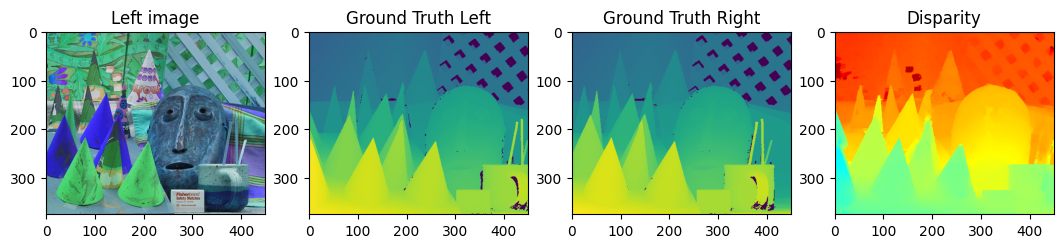

In [10]:
#@title Ejemplo con un par estereo RGB
import cv2
import matplotlib.pyplot as plt

predict_disparity(model,
                  left_path='/content/Fast-ACVNet-ImgProj/test_img/rgb_imgs/left.png',
                  right_path='/content/Fast-ACVNet-ImgProj/test_img/rgb_imgs/right.png')

disp_rgb = cv2.imread('/content/Fast-ACVNet-ImgProj/disp_rgb/disp_rgb.png', cv2.IMREAD_UNCHANGED)
gtL_rgb = cv2.imread('/content/Fast-ACVNet-ImgProj/test_img/rgb_imgs/gtL.png', cv2.IMREAD_UNCHANGED)
gtR_rgb = cv2.imread('/content/Fast-ACVNet-ImgProj/test_img/rgb_imgs/gtR.png', cv2.IMREAD_UNCHANGED)
imgL = cv2.imread('/content/Fast-ACVNet-ImgProj/test_img/rgb_imgs/right.png', cv2.IMREAD_UNCHANGED)

plt.figure(figsize=(13,11))
plt.subplot(141)
plt.imshow(imgL)
plt.title('Left image')
plt.subplot(142)
plt.imshow(gtL_rgb)
plt.title('Ground Truth Left')
plt.subplot(143)
plt.imshow(gtR_rgb)
plt.title('Ground Truth Right')
plt.subplot(144)
plt.imshow(disp_rgb)
plt.title('Disparity')
plt.show()

In [11]:
#@title Cargar las imagenes termicas
import os

left_dir = '/content/Fast-ACVNet-ImgProj/test_img/thermal_imgs/left/'
right_dir = '/content/Fast-ACVNet-ImgProj/test_img/thermal_imgs/right/'

left_imgs = sorted([os.path.join(left_dir, f) for f in os.listdir(left_dir) if f.endswith('.png')])
right_imgs = sorted([os.path.join(right_dir, f) for f in os.listdir(right_dir) if f.endswith('.png')])

assert len(left_imgs) == len(right_imgs), "El número de imágenes izquierdas y derechas no coincide."

In [12]:
test_thermal_pairs(left_imgs, right_imgs)

Guardado: ./disp_thermal/thermal_disp_0.png
Guardado: ./disp_thermal/thermal_disp_1.png
Guardado: ./disp_thermal/thermal_disp_2.png
Guardado: ./disp_thermal/thermal_disp_3.png
Guardado: ./disp_thermal/thermal_disp_4.png


['thermal_disp_4.png', 'thermal_disp_1.png', 'thermal_disp_3.png', 'thermal_disp_0.png', 'thermal_disp_2.png']


Text(0.5, 1.0, 'Depth calculado')

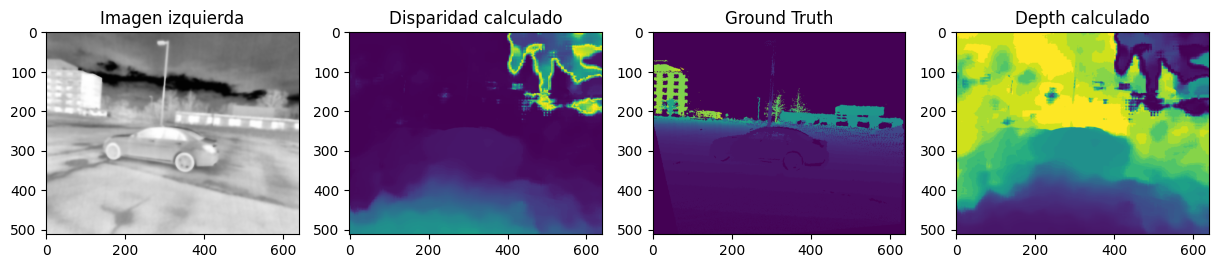

In [13]:
import os
from IPython.display import Image, display
import matplotlib.pyplot as plt
from PIL import Image

# Mostrar lista de archivos
print(os.listdir('/content/Fast-ACVNet-ImgProj/disp_thermal/'))

path = '/content/Fast-ACVNet-ImgProj/disp_thermal/'
pathgt = '/content/Fast-ACVNet-ImgProj/test_img/thermal_imgs/gt/'

disp_imgs_path = sorted([os.path.join(path, f) for f in os.listdir(path) if f.endswith('.png')])
gt_imgs_path = sorted([os.path.join(pathgt, f) for f in os.listdir(pathgt) if f.endswith('.png')])

gt_imgs = []
disp_imgs =[]

for i in range(len(gt_imgs_path)):
  gt_imgs.append(cv2.imread(gt_imgs_path[i], cv2.IMREAD_GRAYSCALE))
  disp_imgs.append(cv2.imread(disp_imgs_path[i], cv2.IMREAD_GRAYSCALE))

img = preprocess_thermal_image(left_imgs[0])

f = 406.33233091474426
baseline = 0.24584925266278748
depth_imgs = [f*baseline/disp for disp in disp_imgs]
depth_imgs = [((img - img.min())/(img.max()-img.min()) * 255).astype(np.uint8) for img in depth_imgs]

# Mostrar una imagen de ejemplo
plt.figure(figsize=(15,8))
plt.subplot(141)
plt.imshow(img)
plt.title('Imagen izquierda')
plt.subplot(142)
plt.imshow(disp_imgs[0])
plt.title('Disparidad calculado')
plt.subplot(143)
plt.imshow(gt_imgs[0])
plt.title('Ground Truth')
plt.subplot(144)
plt.imshow(depth_imgs[0])
plt.title('Depth calculado')

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
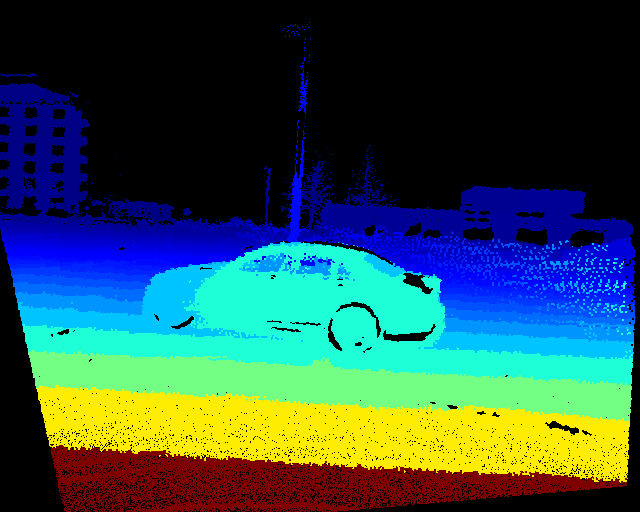

In [14]:
visualize_depth_as_numpy(gt_imgs[0])

array([[[  0,   0, 132],
        [  0,   0, 132],
        [  0,   0, 132],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0, 132],
        [  0,   0, 132],
        [  0,   0, 132],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0, 132],
        [  0,   0, 132],
        [  0,   0, 132],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[255, 137,   0],
        [255,  89,   0],
        [255,  89,   0],
        ...,
        [  0,  76, 255],
        [  0,  76, 255],
        [  0,  76, 255]],

       [[255,  89,   0],
        [255,  89,   0],
        [255,  89,   0],
        ...,
        [  0,  76, 255],
        [  0,  76, 255],
        [  0,  76, 255]],

       [[255, 137,   0],
        [255,  89,   0],
        [255,  89,   0],
        ...,
        [  0,  76, 255],
        [  0,  76, 255],
        [  0,  76, 255]]], dtype=uint8)
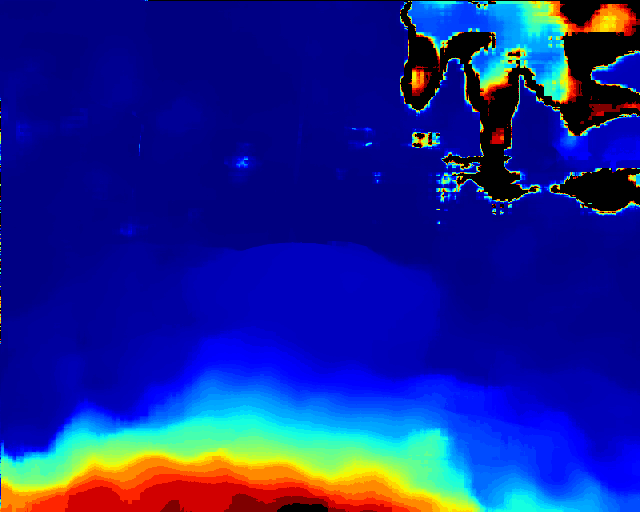

In [15]:
visualize_depth_as_numpy(depth_imgs[0])